<a href="https://colab.research.google.com/github/jovian-explorer/Short-Projects/blob/main/Assigment_6_Eddington_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
###AA 608N : Astrostatistics
---
```
Name : Keshav Aggarwal
Roll no. : 2103121014
```

# Eddington Problem
The aim of this exercise is to write an MCMC code to analyse photographic plates from Eddington’s 1919 eclipse expedition, to determine whether the data favour Newtonian gravity or Einstein’s General Theory of Relativity. Light from stars that passes close to the Sun is deflected, and during an eclipse, these stars can be detected and their displacements measured, when compared with photographs taken when the Sun is far away.

General Relativity predicts that light passing a mass M at distance r will be bent through an angle $$\theta_{GR}(r) = \frac{4GM}{rc^2}$$
whereas an argument based on Newtonian gravity gives half this: $$\theta_{N}(r) = \frac{2GM}{rc^2}$$
We can either treat this as a parameter inference problem, modelling the bending as $$\theta_{N}(r) = \frac{\alpha GM}{rc^2}$$ and inferring $\alpha$, or as a model comparison problem. For this exercise we will do the former.

### **Data Model :**

$$D x^{\text{model exp.}} (\theta,x,y,E_x) = ax+by+c+\alpha E_x$$
$$D y^{\text{model exp.}} (\theta,x,y,E_y) = dx+ey+f+\alpha E_y$$
Where: 


*   $x,y : $  coordinates of the stars
*   $E_x,E_y : $ coefficients of the gravitational displacement
*   $c,f : $ corrections to zero
*   $a,e : $ differences of scale value (caused e.g. by changes in temperature)
*   $b,d : $ depend on the orientation of the two plates
*   $\alpha : $ deflection at unit distance, i.e ($50'$ from the Sun's centre)
 
### **Parameter of interest (POI) :**
*  $\alpha$ 

### **Nuisance parameters (NP) :**
*  $a,b,c,d,e,f$

### **Parameter vector :**
$$\theta = (a,b,c,d,e,f)$$

### **Combined likelihood :**
$$\mathcal{L}(\theta, \text{all data}) = \displaystyle \prod_{i = star} \mathcal{L}_i (\theta,Dx^{\text{obs}},Dy^{\text{obs}})$$
where $\mathcal{L}_i$ is :  

$$\mathcal{L}_i = \frac{1}{\sqrt{2 \pi} \sigma_{Dx}} exp \{ -\frac{1}{2} \frac{(Dx^{\text{obs}}_i - Dx^{\text{model exp.}} (\theta,x_i,y_i,E_{x,i}) )^2}{\sigma^2_{Dx}}\}. \frac{1}{\sqrt{2 \pi} \sigma_{Dy}} exp \{ -\frac{1}{2} \frac{(Dy^{\text{obs}}_i - Dy^{\text{model exp.}} (\theta,x_i,y_i,E_{y,i}) )^2}{\sigma^2_{Dy}}\} $$

where : 
*  $\sigma_{Dx} = 0.05$
*  $\sigma_{Dy} = 0.05$

##**Importing Data :**

In [1]:
# importing libraries
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd
import random
import math as math
import scipy
import scipy.stats

[Link to my github: **https://github.com/jovian-explorer** ](https://github.com/jovian-explorer)

Used in this assignment for the purpose of importing the datasets for just a single time, rather than going through the whole process of uploading files, or mounting drive each time. 

In [2]:
# Data
url_1 = 'https://raw.githubusercontent.com/jovian-explorer/Short-Projects/main/astrostatistics/eddington.csv' # link to the raw file for the dataset from my github
edd = pd.read_csv(url_1,encoding='utf-8')
print(edd)

       x      y     Ex     Ey  Dx_obs_uncorrected  Dy_obs_uncorrected
0 -1.261 -0.160 -0.587  0.036              -1.416              -1.324
1 -0.160 -1.107 -0.557 -0.789              -1.221              -1.312
2  0.334  0.472 -0.186  1.336              -1.054              -0.944
3  0.348  0.360 -0.222  1.574              -1.079              -0.862
4  0.587  1.099  0.080  0.726              -1.012              -0.932
5  0.860  1.321  0.158  0.589              -0.999              -0.948
6  1.079 -0.328  1.540 -0.156              -0.733              -1.019


In [8]:
#Correcting value of Dx and Dy by subtracting -1.500 in Dx and -1.324 in Dy
edd['Dx_obs_corrected'], edd['Dy_obs_corrected'] = (edd.Dx_obs_uncorrected + 1.500), (edd.Dy_obs_uncorrected + 1.324)

# Extracting out data from pandas DataFrame
x,y,Ex,Ey,Dx,Dy = edd.x, edd.y, edd.Ex, edd.Ey, edd.Dx_obs_corrected,edd.Dy_obs_corrected

# storing all the data in single array
data = np.array([x,y,Ex,Ey,Dx,Dy])
print(edd)

       x      y     Ex     Ey  Dx_obs_uncorrected  Dy_obs_uncorrected  \
0 -1.261 -0.160 -0.587  0.036              -1.416              -1.324   
1 -0.160 -1.107 -0.557 -0.789              -1.221              -1.312   
2  0.334  0.472 -0.186  1.336              -1.054              -0.944   
3  0.348  0.360 -0.222  1.574              -1.079              -0.862   
4  0.587  1.099  0.080  0.726              -1.012              -0.932   
5  0.860  1.321  0.158  0.589              -0.999              -0.948   
6  1.079 -0.328  1.540 -0.156              -0.733              -1.019   

   Dx_obs_corrected  Dy_obs_corrected  
0             0.084             0.000  
1             0.279             0.012  
2             0.446             0.380  
3             0.421             0.462  
4             0.488             0.392  
5             0.501             0.376  
6             0.767             0.305  


## **Code :**

In [9]:
sigmad = [0.05,0.05]
# Log of likelihood is defined here
def Log_likh(alpha,a,b,c,d,e,f):
  Dx_mod = a*data[0] + b*data[1] + c + alpha*data[2]
  Dy_mod = d*data[0] + e*data[1] + f + alpha*data[3]
 
  Diff_x= data[4] - Dx_mod
  Diff_y= data[5] - Dy_mod

  ln_L = (-1/(2*sigmad[0]**2) * np.dot(Diff_x , Diff_x))+(-1/(2*sigmad[1]**2) * np.dot(Diff_y , Diff_y))
  return ln_L

In [10]:
# Metropolis - Hasting Sampler
N=200000
Nburn = 250
Naccept = 0
alpha_accept = [0]
a_accept     = [0]
b_accept     = [0] 
c_accept     = [0]
d_accept     = [0]
e_accept     = [0]
f_accept     = [0]
acpt_lkhd    = []
for j in range(N):
    alpha_random = np.random.normal(alpha_accept[-1], 0.015) 
    a_random     = np.random.normal(a_accept[-1], 0.015)     
    b_random     = np.random.normal(b_accept[-1], 0.015)     
    c_random     = np.random.normal(c_accept[-1], 0.015)     
    d_random     = np.random.normal(d_accept[-1], 0.015)     
    e_random     = np.random.normal(e_accept[-1], 0.015)     
    f_random     = np.random.normal(f_accept[-1], 0.015)  
    theta_random = [alpha_random, a_random, b_random, c_random, d_random, e_random, f_random]   

    #Calulating log of likelihood of these randomly generated 
    N_log_liklh = Log_likh(alpha_random,a_random,b_random,c_random,d_random,e_random,f_random)

    #calulating acceptance probability
    acc_lkh = min(np.exp(N_log_liklh - Log_likh(alpha_accept[-1],a_accept[-1],b_accept[-1],c_accept[-1],d_accept[-1],e_accept[-1],f_accept[-1])), 1)

    if np.random.uniform(0, 1) < acc_lkh:
        alpha_accept   = np.append(alpha_accept, alpha_random)
        a_accept       = np.append(a_accept, a_random)
        b_accept       = np.append(b_accept, b_random)
        c_accept       = np.append(c_accept, c_random)
        d_accept       = np.append(d_accept, d_random)
        e_accept       = np.append(e_accept, e_random)
        f_accept       = np.append(f_accept, f_random)
        acpt_lkhd           = np.append(acpt_lkhd, N_log_liklh)
        Naccept+=1

In [12]:
# Print the mean values
print('alpha_mean=',np.mean(alpha_accept[200:])*19.8)
print('a_mean=',np.mean(a_accept[200:])*19.8)
print('b_mean=',np.mean(b_accept[200:])*19.8)
print('c_mean=',np.mean(c_accept[200:])*19.8)
print('d_mean=',np.mean(d_accept[200:])*19.8)
print('e_mean=',np.mean(e_accept[200:])*19.8)
print('f_mean=',np.mean(f_accept[200:])*19.8)

alpha_mean= 2.6660174062419326
a_mean= 3.300918585873998
b_mean= -0.17377101966417416
c_mean= 7.555030191424571
d_mean= 2.7940805336944283
e_mean= 0.3442838712086583
f_mean= 3.3984988376006817


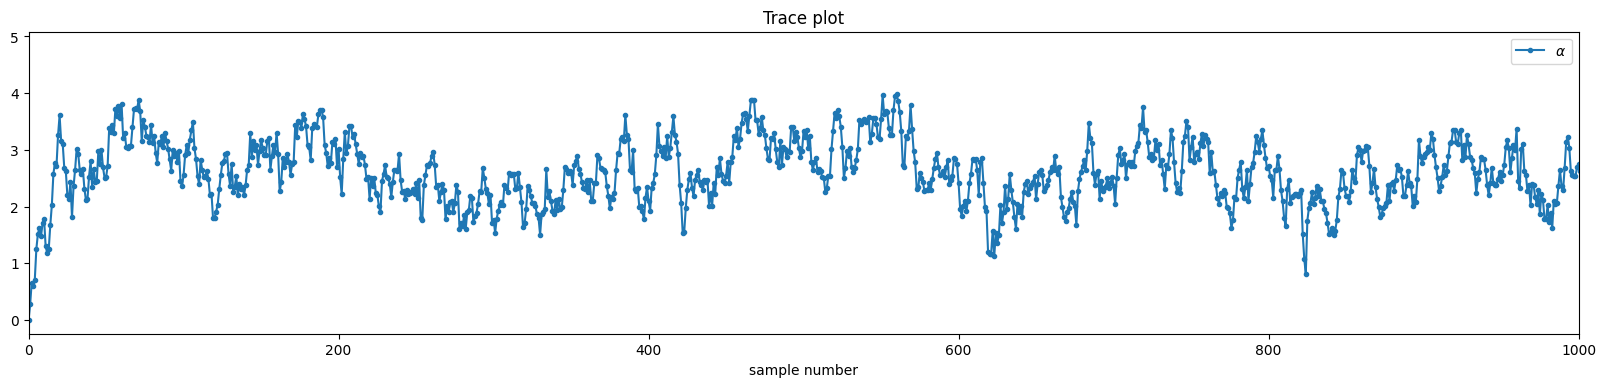

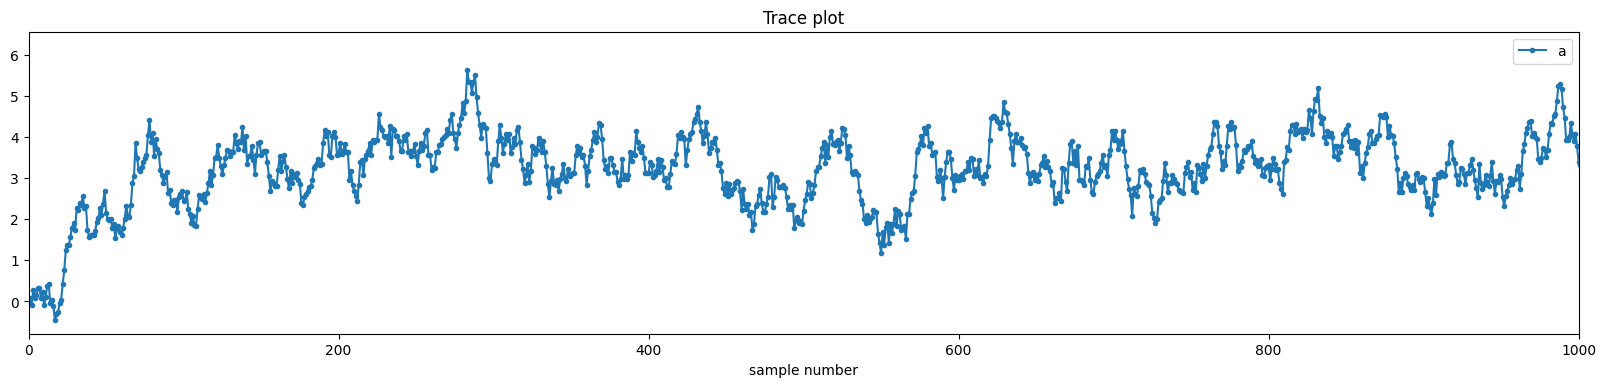

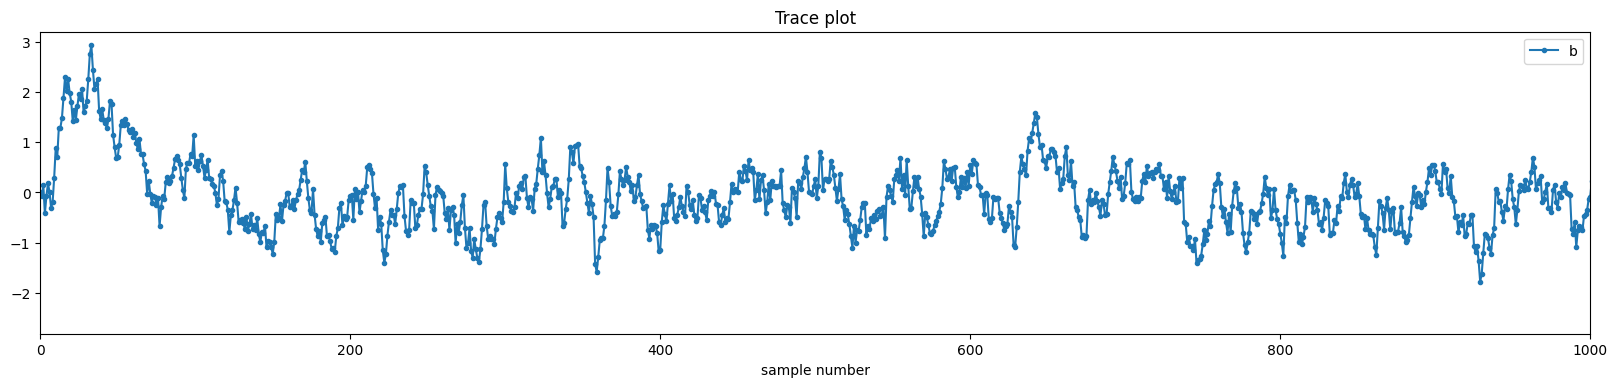

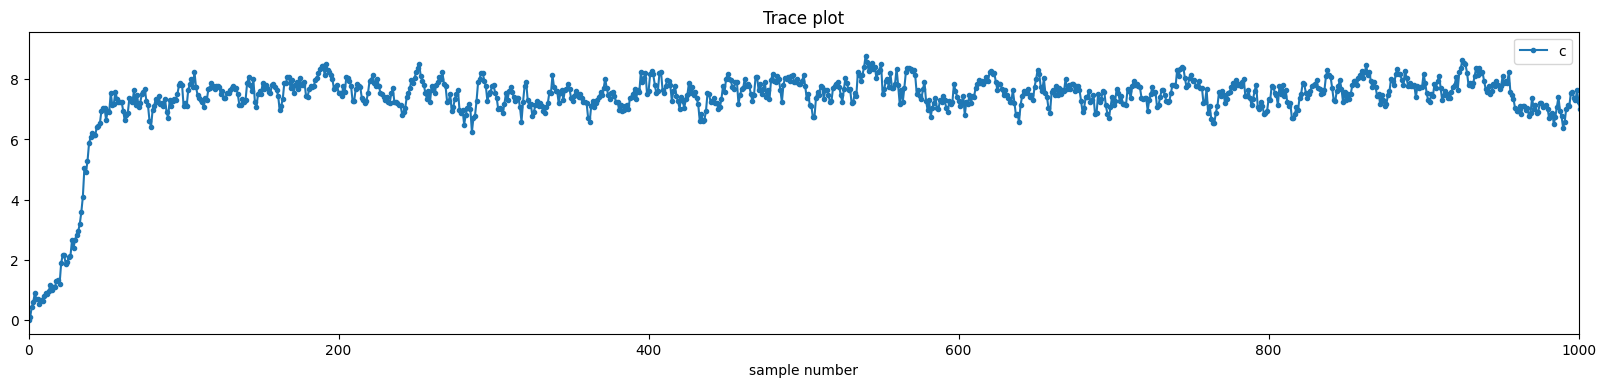

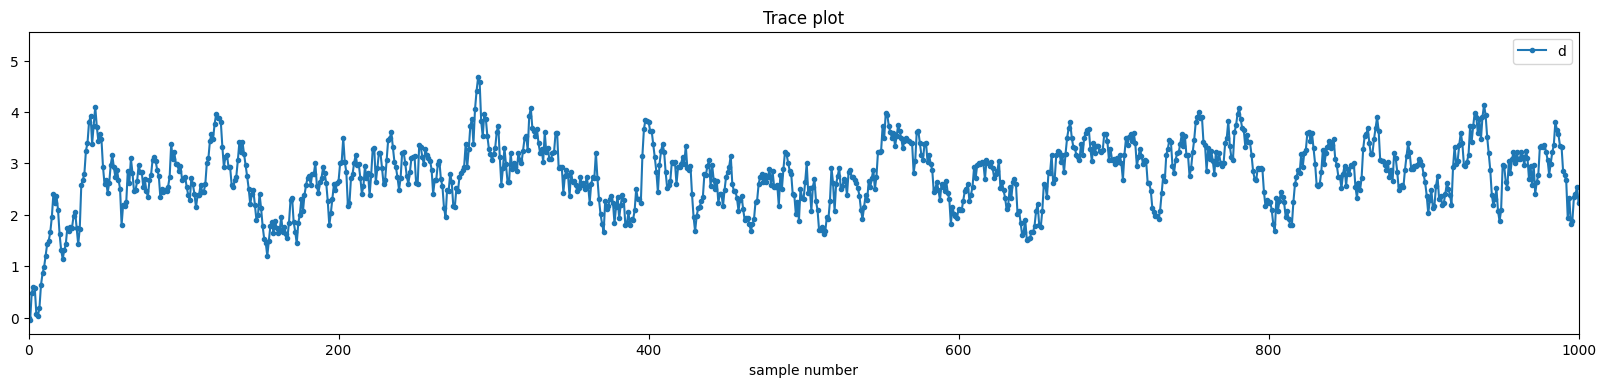

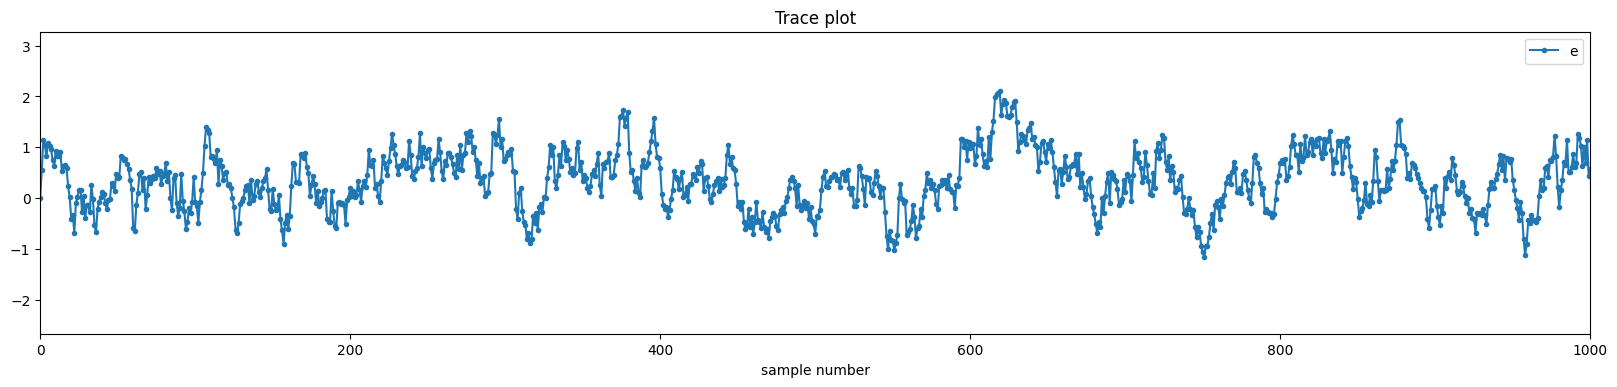

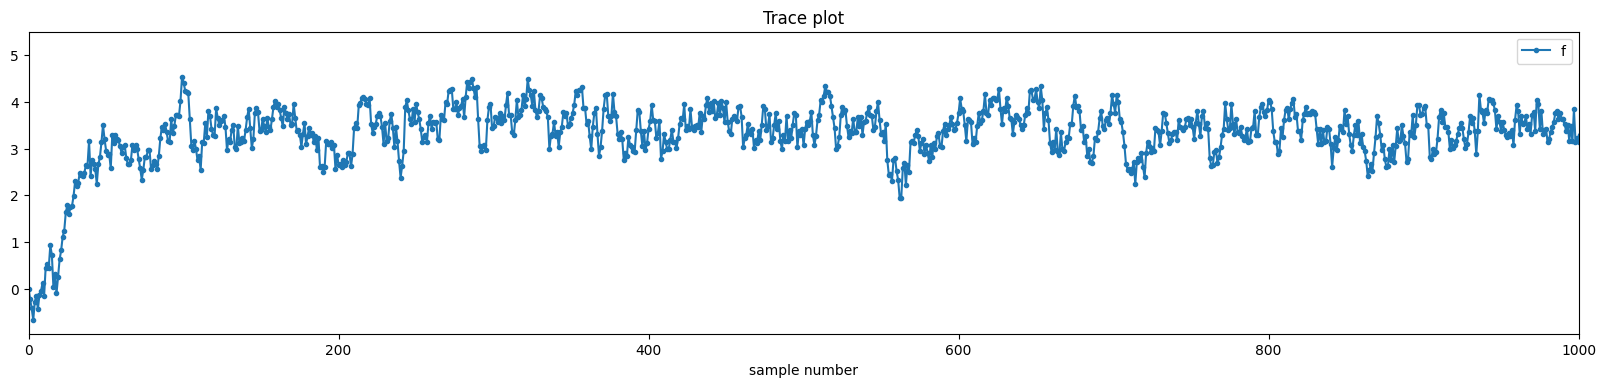

In [16]:
#Plots trace plots
plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(alpha_accept),1), alpha_accept*19.8, marker='.', label = r"$\alpha$")
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(a_accept),1), a_accept*19.8, marker='.',label = 'a')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(b_accept),1), b_accept*19.8, marker='.',label = 'b')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(c_accept),1), c_accept*19.8, marker='.',label = 'c')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(d_accept),1), d_accept*19.8, marker='.',label = 'd')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(e_accept),1), e_accept*19.8, marker='.',label = 'e')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(f_accept),1), f_accept*19.8, marker='.', label = 'f')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()

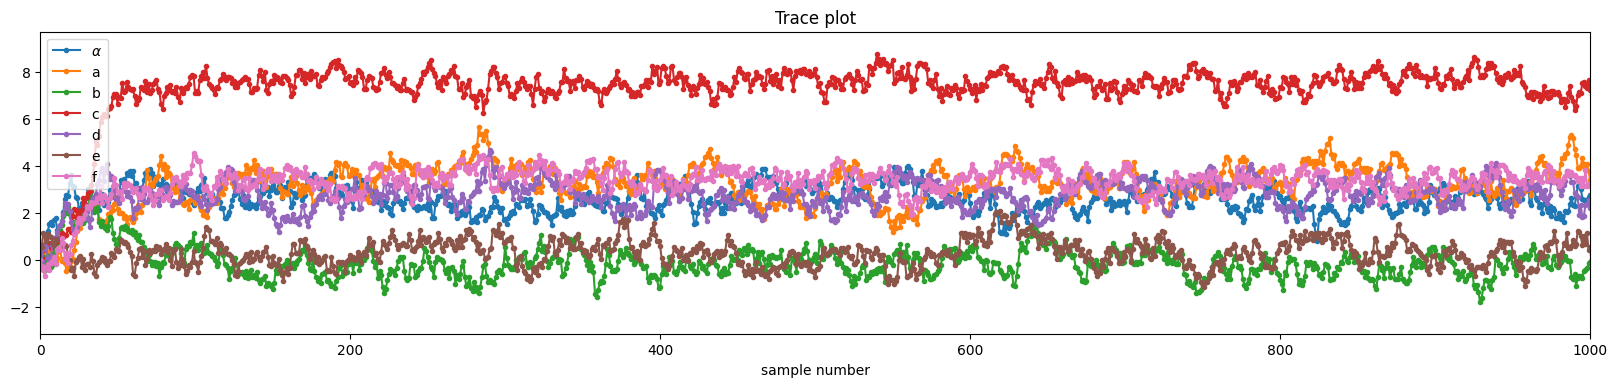

In [17]:
#Plots trace plots
plt.figure(figsize=(20,4), dpi=100)
plt.plot(np.arange(0, len(alpha_accept),1), alpha_accept*19.8, marker='.', label = r"$\alpha$")
plt.plot(np.arange(0, len(a_accept),1), a_accept*19.8, marker='.',label = 'a')
plt.plot(np.arange(0, len(b_accept),1), b_accept*19.8, marker='.',label = 'b')
plt.plot(np.arange(0, len(c_accept),1), c_accept*19.8, marker='.',label = 'c')
plt.plot(np.arange(0, len(d_accept),1), d_accept*19.8, marker='.',label = 'd')
plt.plot(np.arange(0, len(e_accept),1), e_accept*19.8, marker='.',label = 'e')
plt.plot(np.arange(0, len(f_accept),1), f_accept*19.8, marker='.', label = 'f')
plt.title("Trace plot")
plt.xlabel("sample number")
plt.xlim(0,1000)
plt.legend()
plt.show()